In [30]:
import yfinance as yf
import pandas as pd
import os

In [31]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

In [32]:
sp500.index = pd.to_datetime(sp500.index)

In [33]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,0,0
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,0,0
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,0,0
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,0,0
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,0,0
...,...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,0,0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,0,0
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,0,0


<AxesSubplot:xlabel='Date'>

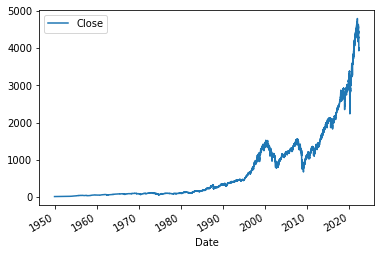

In [34]:
sp500.plot.line(y="Close", use_index=True)

In [35]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [36]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [37]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [38]:
sp500 = sp500.loc["1990-01-01":].copy()

In [39]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932,0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078,0
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,4023.889893,1


In [40]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [41]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.42857142857142855

<AxesSubplot:xlabel='Date'>

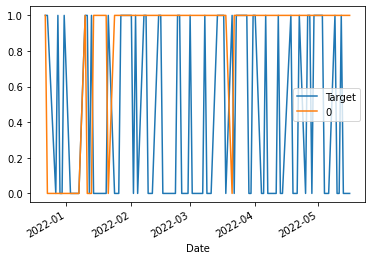

In [42]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [43]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [44]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [45]:
predictions = backtest(sp500, model, predictors)

In [46]:
predictions["Predictions"].value_counts()

0    3321
1    2336
Name: Predictions, dtype: int64

In [47]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5351027397260274

In [48]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.536857
0    0.463143
Name: Target, dtype: float64

In [49]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [50]:
sp500 = sp500.dropna()

In [51]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09,4081.270020,4081.270020,3975.479980,3991.239990,4746120000,4001.050049,1,0.983721,0.0,0.962343,2.0,0.914756,26.0,0.898738,132.0,1.158960,553.0
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932,0,1.001227,1.0,0.972892,2.0,0.918469,27.0,0.901037,132.0,1.161381,553.0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078,0,0.991700,1.0,0.974166,1.0,0.904963,27.0,0.886394,131.0,1.141860,553.0


In [52]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [59]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [60]:
predictions = backtest(sp500, model, new_predictors)

In [61]:
predictions["Predictions"].value_counts()

0.0    3863
1.0     793
Name: Predictions, dtype: int64

In [62]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5737704918032787

In [57]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.54811
0    0.45189
Name: Target, dtype: float64

In [58]:
model.feature_importances_

array([0.15724273, 0.01367935, 0.15585179, 0.03110826, 0.14518692,
       0.06144567, 0.13427156, 0.08131531, 0.13399453, 0.08590387])